# Scanning the BP dataset with pysegy

This notebook demonstrates how to download the BP 1994 2-D seismic dataset, scan it using the `pysegy` utilities and then visualise the source and receiver positions as well as a few shot or receiver gathers.

In [1]:
import pysegy
import urllib, gzip, os, shutil
import matplotlib.pyplot as plt


In [2]:
bp_url = 'http://s3.amazonaws.com/open.source.geoscience/open_data/bpstatics94/7m_shots_0601_0869.segy.gz'
local_gz = '7m_shots_0601_0869.segy.gz'
local_segy = '7m_shots_0601_0869.segy'

if not os.path.exists(local_segy):
    print('Downloading BP dataset...')
    with urllib.request.urlopen(bp_url) as resp, open(local_gz, 'wb') as f:
        shutil.copyfileobj(resp, f)
    with gzip.open(local_gz, 'rb') as gz, open(local_segy, 'wb') as out:
        shutil.copyfileobj(gz, out)


In [3]:

# Scan the SEGY file to find shot locations and offsets
scan = pysegy.segy_scan(local_segy)
fh = scan.fileheader
print(f'Total shots: {len(scan)}')
print('Samples per trace:', fh.bfh.ns)


Scanning 1 files in . with 8 threads
ThreadPoolExecutor-0_0 scanning file 7m_shots_0601_0869.segy
Header for 7m_shots_0601_0869.segy: ns=1152 dt=5400
ThreadPoolExecutor-0_0 found 136 shots in 7m_shots_0601_0869.segy
Combined scan has 136 shots
Total shots: 136
Samples per trace: 1152


In [4]:
# Display human-readable headers
fh

BinaryFileHeader:
    Job                           :         0
    Line                          :         0
    Reel                          :         1
    DataTracePerEnsemble          :      3008
    AuxiliaryTracePerEnsemble     :         0
    dt                            :      5400
    dtOrig                        :         0
    ns                            :      1152
    nsOrig                        :         0
    DataSampleFormat              :         1
    EnsembleFold                  :         0
    TraceSorting                  :         0
    VerticalSumCode               :         0
    SweepFrequencyStart           :         0
    SweepFrequencyEnd             :         0
    SweepLength                   :         0
    SweepType                     :         0
    SweepChannel                  :         0
    SweepTaperlengthStart         :         0
    SweepTaperLengthEnd           :         0
    TaperType                     :         0
    CorrelatedDa

In [5]:
example_hdr = scan.read_headers(0, keys=['SourceX', 'GroupX', 'ns', "dt", "SourceDepth"])[0]
example_hdr

BinaryTraceHeader:
    SourceX                       :     12500
    GroupX                        :      5005
    ns                            :      1152
    dt                            :      5400
    SourceDepth                   :      6250

In [6]:
# Access ShotRecord directly and use lazy data
rec = scan[0]
hdr = rec.read_headers(keys=['SourceX'])[0]
block = rec.data
block

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(1152, 3007), dtype=float32)

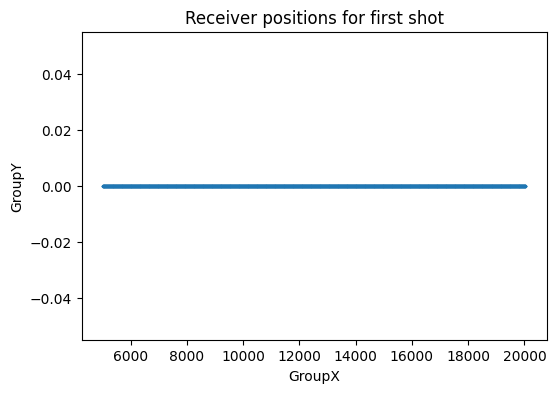

In [7]:
# Receiver coordinates for a shot
rec = scan[0]
coords = rec.rec_coordinates
plt.figure(figsize=(6,4))
plt.scatter(coords[:,0], coords[:,1], s=2)
plt.xlabel('GroupX')
plt.ylabel('GroupY')
plt.title('Receiver positions for first shot')
plt.show()

Shot 1 - Samples: 1152, Traces: 3007
Shot 2 - Samples: 1152, Traces: 1


/Users/mathiaslouboutin/Devitos/pysegy/pysegy/plotting.py:122: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  im = plt.imshow(


Shot 3 - Samples: 1152, Traces: 3008


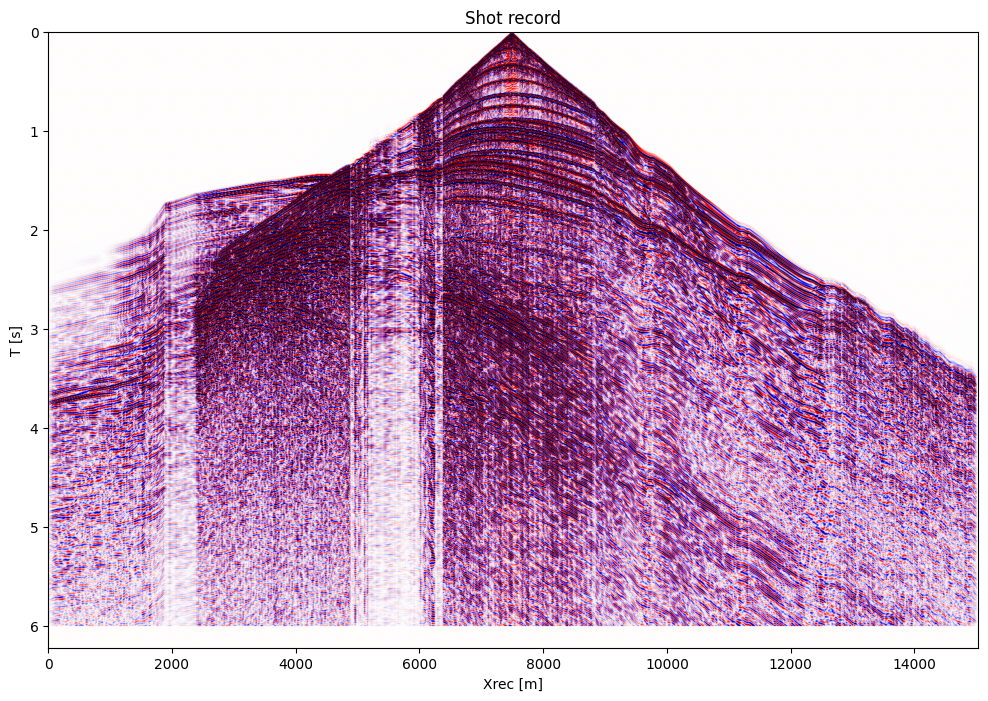

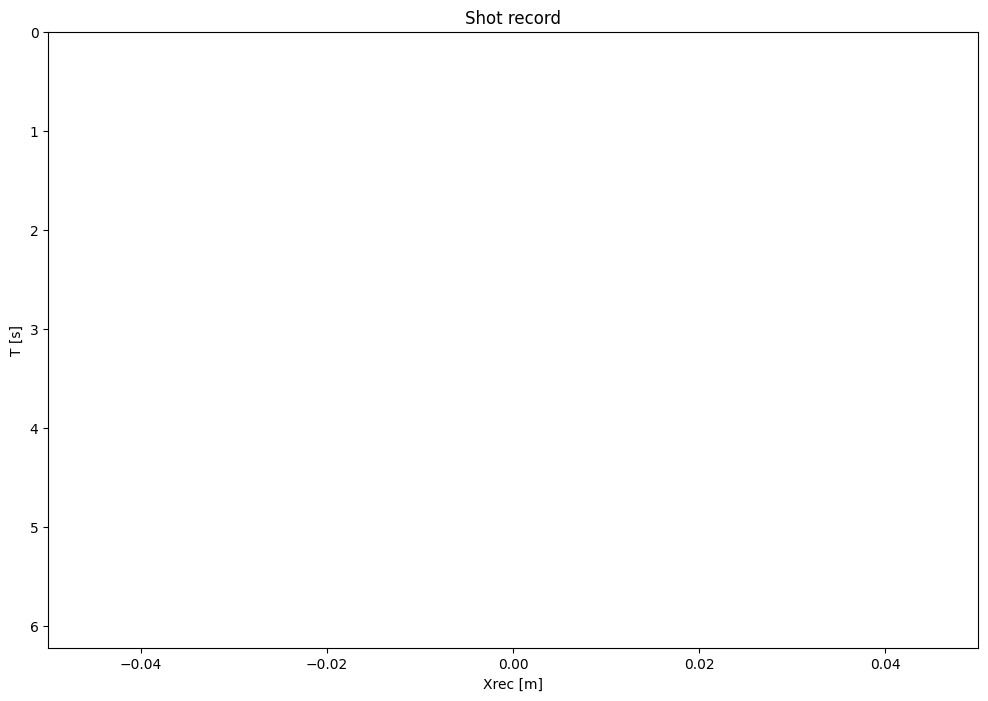

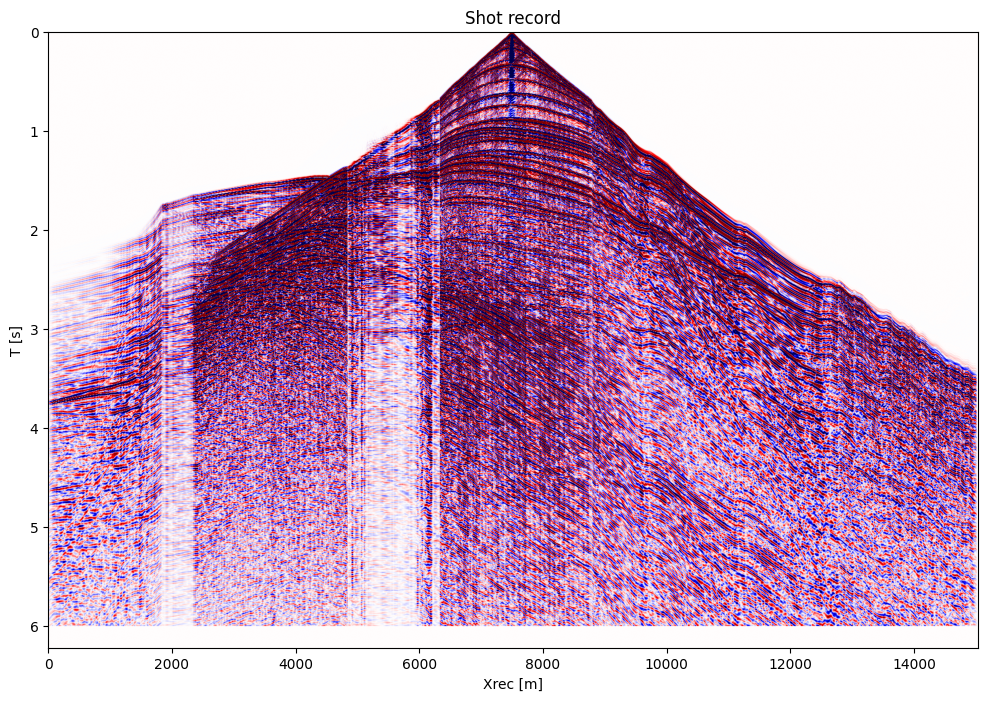

In [8]:

# Plot a few shot gathers using the lazy reader
for i in range(3):
    block = scan[i]
    print(f'Shot {i+1} - Samples: {block.data.shape[0]}, Traces: {block.data.shape[1]}')
    plt.figure(figsize=(12, 8))
    pysegy.plot_sdata(block, perc=90, new_fig=False, cmap="seismic")

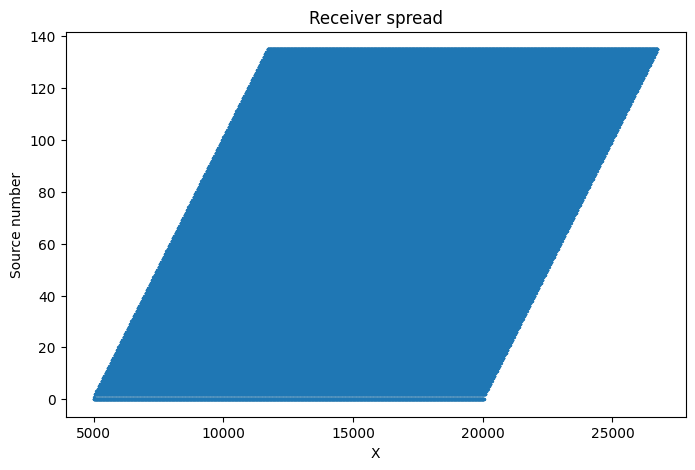

In [9]:

# Receiver spread across all sources
xvals = []
src_ids = []
for i in range(len(scan)):
    hdrs = scan.read_headers(i, keys=['GroupX'])
    xvals.extend(h.GroupX for h in hdrs)
    src_ids.extend([i] * len(hdrs))
plt.figure(figsize=(8,5))
plt.scatter(xvals, src_ids, s=2)
plt.xlabel('X')
plt.ylabel('Source number')
plt.title('Receiver spread')
plt.show()


# Scan by receiver coordinates and plot a gather

In [10]:
rec_scan = pysegy.segy_scan(local_segy, by_receiver=True)
print(f'Total receiver gathers: {len(rec_scan)}')

Scanning 1 files in . with 8 threads
ThreadPoolExecutor-4_0 scanning file 7m_shots_0601_0869.segy
Header for 7m_shots_0601_0869.segy: ns=1152 dt=5400
ThreadPoolExecutor-4_0 found 4348 shots in 7m_shots_0601_0869.segy
Combined scan has 4348 shots
Total receiver gathers: 4348


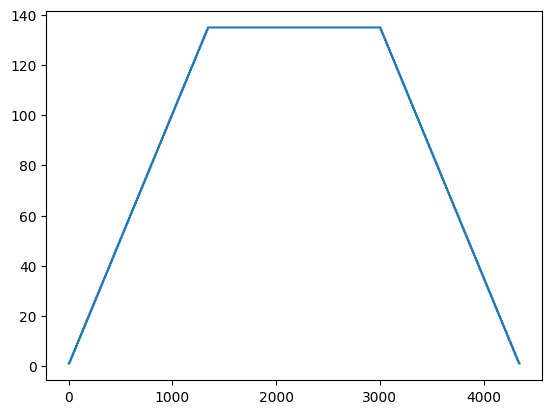

In [11]:
plt.plot(rec_scan.counts)

Receiver gather 1 - Samples: 1152, Traces: 135
Receiver gather 2 - Samples: 1152, Traces: 135
Receiver gather 3 - Samples: 1152, Traces: 135


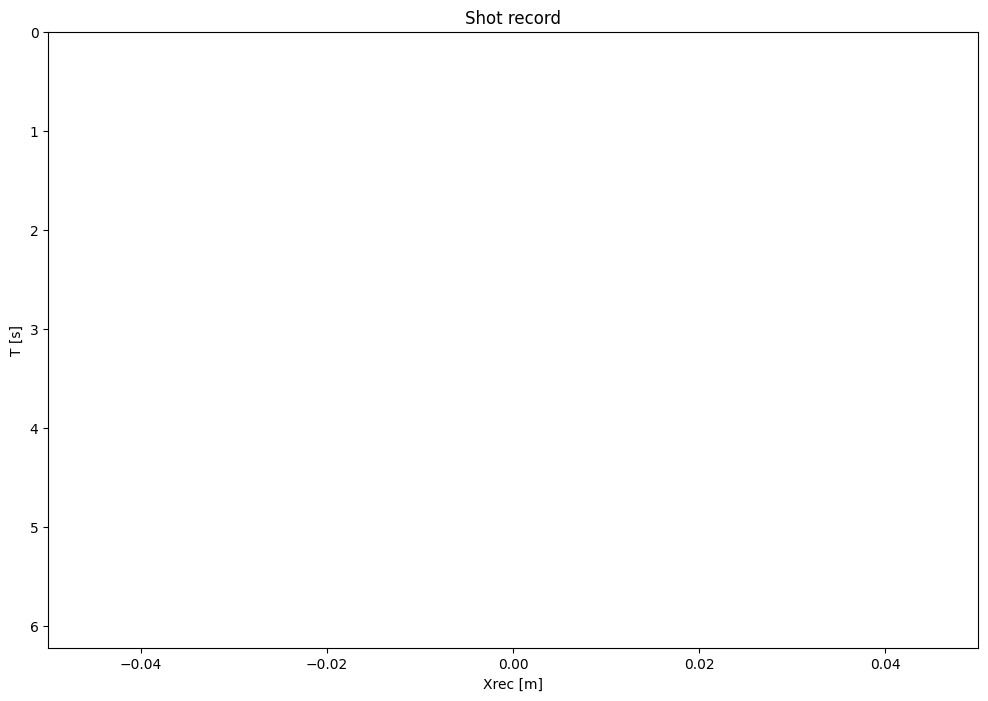

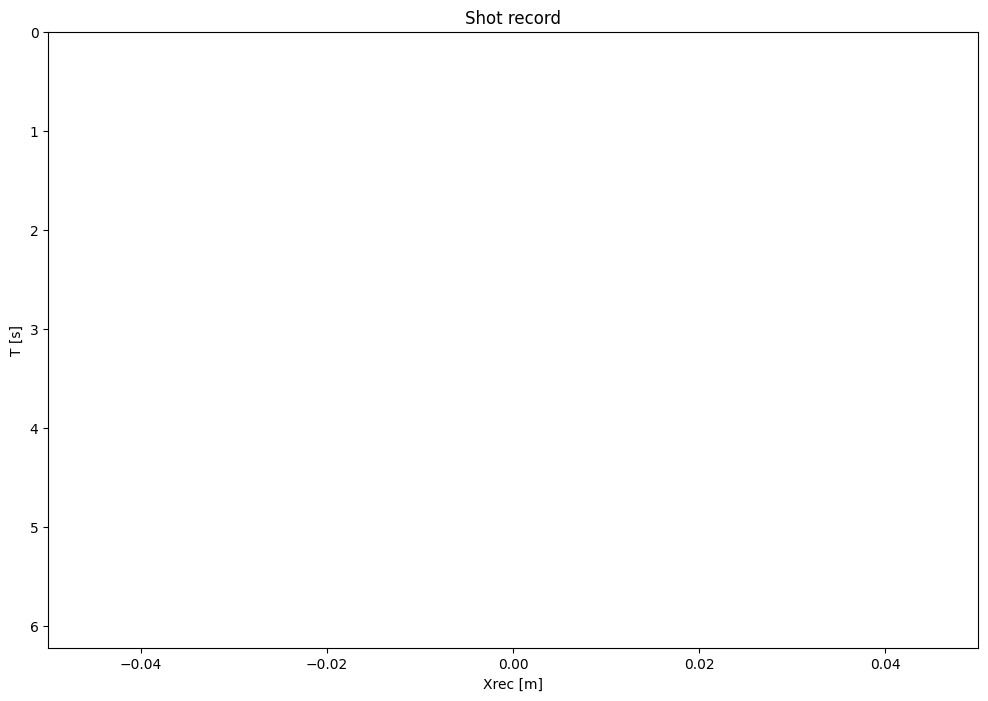

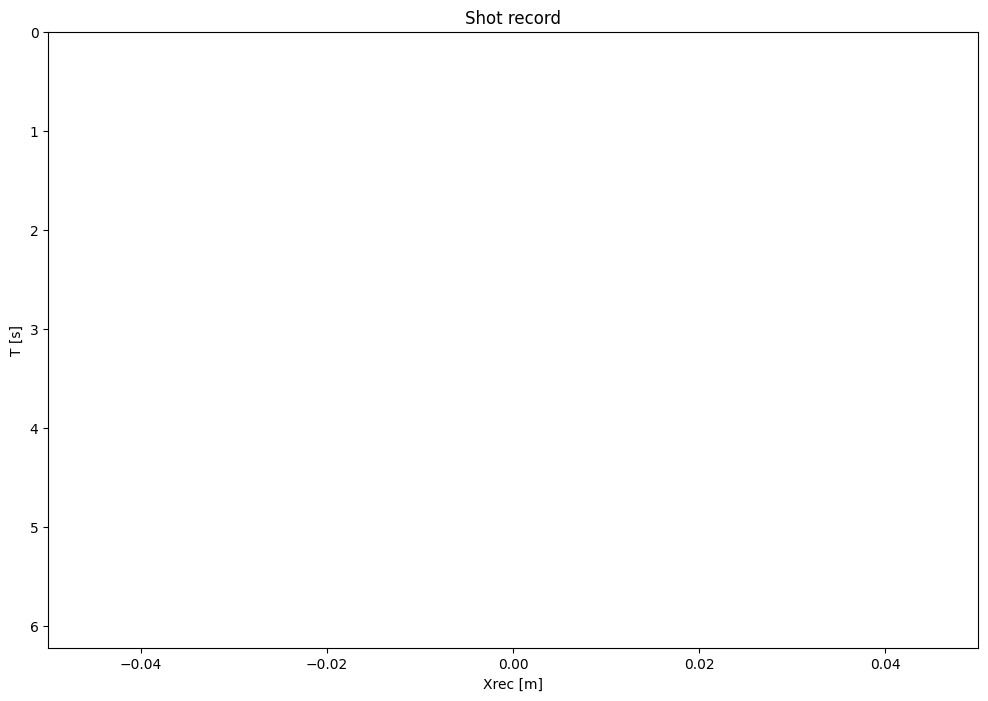

In [ ]:
# Plot a few receiver gathers using the lazy reader
for i in range(3):
    block = rec_scan[2000+i]
    print(f'Receiver gather {i+1} - Samples: {block.data.shape[0]}, Traces: {block.data.shape[1]}')
    plt.figure(figsize=(12, 8))
    pysegy.plot_sdata(block, perc=90, new_fig=False, cmap="seismic")